In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-a4/train_file.json
/kaggle/input/nlp-a4/val_file.json


In [3]:
# Importing libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import json
import math
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [4]:
# Mapping each emotion in the dataset to an integer index
emotion_to_index = {
    'neutral': 0,
    'joy': 1,
    'sadness': 2,
    'fear': 3,
    'anger': 4,
    'surprise': 5,
    'disgust': 6
}

In [5]:
# Training and validation file paths
train_path = '/kaggle/input/nlp-a4/train_file.json'
val_path = '/kaggle/input/nlp-a4/val_file.json'

In [6]:
with open(train_path, 'r') as file:
    train_data = json.load(file)

In [7]:
# Setting cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
class FlipDatasetNew(Dataset):
    def __init__(self, path, tokenizer, max_length=50, max_utterances=10, subset_ratio=None):
        with open(path, 'r') as file:
            self.data = json.load(file)

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.max_utterances = max_utterances
        self.subset_ratio = subset_ratio
        self.positional_embeddings = self.get_sinusoidal_embeddings(1, 50)

    def __len__(self):
        return int(len(self.data) * self.subset_ratio) if self.subset_ratio else len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Emotions
        emotions = [emotion_to_index[emotion] for emotion in item['emotions']]

        # Utterances
        utterances = [self.tokenizer(utterance, max_length=self.max_length - 1, padding='max_length',
                                truncation=True, return_tensors='pt') for utterance in item['utterances']]

        # Stacking utterance
        utterances_id = torch.stack([
            torch.cat((
                torch.tensor([emotions[idx]]),
                utterance['input_ids'].squeeze(0)
            ), dim=0) + self.positional_embeddings[idx][0]
            for idx, utterance in enumerate(utterances)
        ])

        # utterances_id = torch.stack([
        #     torch.cat((
        #         torch.tensor([emotions[idx]]),
        #         utterance['input_ids'].squeeze(0)
        #     ), dim=0)
        #     for idx, utterance in enumerate(utterances)
        # ])

        # Padding or trimming the utterances to max_utterances
        if utterances_id.size(0) >= self.max_utterances:
            utterances_id = utterances_id[utterances_id.size(0) - self.max_utterances:]
        elif utterances_id.size(0) < self.max_utterances:
            utterances_id = torch.cat((
                utterances_id,
                torch.zeros(self.max_utterances - utterances_id.size(0), self.max_length).long()
            ), dim=0)

        # Stacking attention masks
        attention_masks = torch.stack([
            torch.cat((
                torch.tensor([1]),  # Add 1 to indicate the start of a new sequence
                utterance['attention_mask'].squeeze(0)
            ), dim=0) for utterance in utterances
        ])

        # Padding or trimming the attention masks to max_utterances
        if attention_masks.size(0) >= self.max_utterances:
            attention_masks = attention_masks[attention_masks.size(0) - self.max_utterances:]
        elif attention_masks.size(0) < self.max_utterances:
            attention_masks = torch.cat((
                attention_masks,
                torch.zeros(self.max_utterances - attention_masks.size(0), self.max_length).long()
            ), dim=0)

        # Convert attention_masks to boolean
        attention_masks = attention_masks.bool()

        # # Flatten the utterances and attention masks
        # utterances_id = utterances_id.flatten()
        # attention_masks = attention_masks.flatten()

        # Triggers
        try:
            triggers = item['triggers']
            triggers = torch.tensor(triggers)
            if triggers.size(0) >= self.max_utterances:
                triggers = triggers[triggers.size(0) - self.max_utterances:]
            elif triggers.size(0) < self.max_utterances:
                triggers = torch.cat((
                    triggers,
                    torch.zeros(self.max_utterances - triggers.size(0)).long()
                ), dim=0)
                # triggers += [0] * (self.max_utterances - triggers.size(0))
        except RuntimeError:
            triggers = torch.zeros(self.max_utterances).long()

        return {
            'utterances': utterances_id,
            'attention_masks': attention_masks,
            'triggers': triggers
        }

    def get_sinusoidal_embeddings(self, d_model, max_len):
        """
        Generates sinusoidal positional embeddings.

        Args:
        - d_model (int): The dimensionality of the embeddings.
        - max_len (int): The maximum length of the sequence.

        Returns:
        - torch.Tensor: A tensor of shape [max_len, d_model] containing sinusoidal positional embeddings.
        """
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

In [9]:
# Dataloaders
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = FlipDatasetNew(train_path, tokenizer, max_length=50, max_utterances=10, subset_ratio=0.5)
val_dataset = FlipDatasetNew(val_path, tokenizer, max_length=50, max_utterances=10)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
class EmotionFlipModel(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', hidden_dim=256, dropout=0.2):
        super(EmotionFlipModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model).to(device)
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        # self.sigmoid = nn.Sigmoid()
        # self.ReLU = nn.ReLU()

    def forward(self, utterances, masks, triggers):
        # print(utterances.shape, masks.shape, triggers.shape)
        utterances = utterances.long()

        # Flatten the utterances and masks
        utterances = utterances.view(8, -1)
        masks = masks.view(8, -1)
        # print(utterances.shape, masks.shape, triggers.shape)

        # BERT
        bert_output = self.bert(utterances, attention_mask=masks).last_hidden_state

        # LSTM
        lstm_output, _ = self.lstm(bert_output)

        # Taking sum of each consecutive 50 tokens
        num_full_segments = lstm_output.shape[1] // 50
        if num_full_segments > 0:
            lstm_output = lstm_output[:, :num_full_segments * 50]
            lstm_output = lstm_output.view(lstm_output.shape[0], num_full_segments, 50, -1)
            lstm_output = lstm_output.sum(dim=2)
        else:
            lstm_output = lstm_output.sum(dim=1, keepdim=True)

        # Classification
        fc_output = self.fc(self.dropout(lstm_output))
        fc_output = fc_output.squeeze(-1)

        # Sigmoid
        # output = self.sigmoid(fc_output)
        # output = (output >= 0.5).float()

        # # ReLU
        # output = self.ReLU(fc_output)

        return fc_output

In [11]:
# Model, loss and optimizer
model = EmotionFlipModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [52]:
# Training loop
num_epochs = 5
training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(tqdm(train_loader)):
        if i == len(train_loader) - 1:
            break
        utterances = data['utterances'].to(device)
        masks = data['attention_masks'].to(device)
        triggers = data['triggers'].to(device)

        optimizer.zero_grad()
        outputs = model(utterances, masks, triggers)
        loss = criterion(outputs, triggers.float())
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # # After loss.backward(), add:
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f"Gradient magnitude for {name}: {param.grad.abs().mean()}")
        #         break
        #     else:
        #         print(f"No gradient for {name}")

        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(tqdm(val_loader)):
            if i == len(val_loader) - 1:
                break
            utterances = data['utterances'].to(device)
            masks = data['attention_masks'].to(device)
            triggers = data['triggers'].to(device)

            outputs = model(utterances, masks, triggers)
            loss = criterion(outputs, triggers.float())
            val_loss += loss.item()

    training_losses.append(running_loss / len(train_loader))
    validation_losses.append(val_loss / len(val_loader))

    print('Epoch {}:\n\tTraining Loss: {}\n\tValidation Loss: {}'.format(
        epoch + 1, running_loss / len(train_loader), val_loss / len(val_loader)))

 99%|█████████▉| 105/106 [00:20<00:00,  5.08it/s]


Epoch 1:
	Training Loss: 0.5420349033734809
	Validation Loss: 0.34089978896784334


 99%|█████████▉| 105/106 [00:20<00:00,  5.09it/s]


Epoch 2:
	Training Loss: 0.4040550170422165
	Validation Loss: 0.30178802755643735


 99%|█████████▉| 105/106 [00:20<00:00,  5.07it/s]


Epoch 3:
	Training Loss: 0.35826041650080004
	Validation Loss: 0.2881823922946768


 99%|█████████▉| 105/106 [00:20<00:00,  5.11it/s]


Epoch 4:
	Training Loss: 0.3294102514948325
	Validation Loss: 0.27905903194310533


 99%|█████████▉| 105/106 [00:20<00:00,  5.09it/s]

Epoch 5:
	Training Loss: 0.3181518387243646
	Validation Loss: 0.26997929769304563


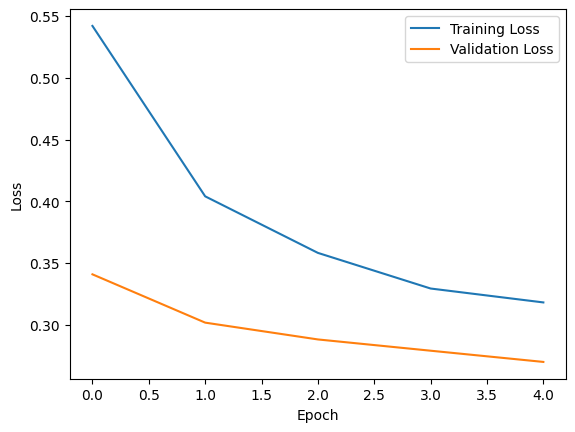

In [53]:
# Graphing the losses
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
# Saving the model after sending it to cpu
model.to('cpu')
torch.save(model.state_dict(), 'm3.pth')

In [12]:
# Loading the model
model = EmotionFlipModel()
model.load_state_dict(torch.load('m3.pth'))
model.to(device)

EmotionFlipModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [14]:
# FInd f1 score
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader)):
        if i == len(train_loader) - 1:
            break
        utterances = data['utterances'].to(device)
        masks = data['attention_masks'].to(device)
        triggers = data['triggers'].to(device)

        outputs = model(utterances, masks, triggers)
        outputs = (outputs >= 0.5).float()
        y_true.extend(triggers.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: {}'.format(f1))

100%|█████████▉| 421/422 [01:19<00:00,  5.27it/s]

F1 Score: 0.3893033328266201
